In [1]:
import xarray as xr
from sqlalchemy import create_engine, inspect

In [2]:
# Load db
engine = create_engine('sqlite:///C:\\Users\\brlam\\Downloads\\exampleco_db.db', echo=False)
#I used the absolute path, using the relative path we have sqlite:///exampleco_db.db

In [3]:
# View tables
inspector = inspect(engine)
inspector.get_table_names()

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

In [4]:
#Example query
query = "SELECT * FROM static_data"
engine.execute(query).fetchall()

[('machine_0', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_1', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_2', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_3', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_4', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_5', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_6', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_7', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_8', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_9', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_10', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_11', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_12', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_13', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_14', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_15', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_16', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_17', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_18', '2019-01-01', 'Model B

In [5]:
#Read feat tables into dataframes
import pandas as pd
import numpy as np

feat_0 = pd.read_sql_table('feat_0', engine)
feat_1 = pd.read_sql_table('feat_1', engine)
feat_2 = pd.read_sql_table('feat_2', engine)
feat_3 = pd.read_sql_table('feat_3', engine)

In [6]:
#Merge dataframes

df = pd.merge(pd.merge(feat_0, feat_1, how = 'left', left_on = ['timestamp', 'machine'], right_on = ['timestamp', 'machine'], suffixes = ["_0", "_1"]), 
                    pd.merge(feat_2, feat_3, how = 'left', left_on = ['timestamp', 'machine'], right_on = ['timestamp', 'machine'], suffixes = ["_2", "_3"]))
df.head()

,timestamp,machine,value_0,value_1,value_2,value_3
0,2019-01-01 00:00:00.000000,machine_0,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201,machine_0,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402,machine_0,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603,machine_0,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804,machine_0,28.057100,3.691359,21.984744,13.670561


In [7]:
#Replace column names with "feat" instead of "value"
df.columns = df.columns.str.replace("value", "feat")

#Summary statistics
df.describe()

#It seems like most machines have failed. The standard deviation and min/max values are very large in absolute value compared to
#the IQR. However, we cannot simply use these to identify outliers, especially since we know there is heterogeneity in machine
#behavior. We'll need to take a closer look at the data.

,feat_0,feat_1,feat_2,feat_3
count,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.002310,-0.185737,0.160426,0.294656
std,57.914469,55.542377,56.798872,56.713326
min,-326.441784,-285.538100,-299.880322,-365.362164
25%,-0.010102,-0.010187,-0.010039,-0.010113
50%,0.000065,-0.000154,0.000016,-0.000048
75%,0.010212,0.010003,0.010073,0.010129
max,319.144282,282.440976,297.623913,359.939478


In [8]:
#NOTE: Normally I prefer to use datatable for EDA as I find it faster and more elegant than pandas. For the sake of this challenge,
#I will stick with pandas

In [52]:
#Let's examine the performance of one of the machines to do a visual check for outliers
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#m_10 = df[df['machine'] == 'machine_10']
#print(m_10)

#pd.set_option("display.max_rows", 50, "display.max_columns", 50)

#It seems like there are some values of around abs(250) for each of the features which seem like outliers.

C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is 

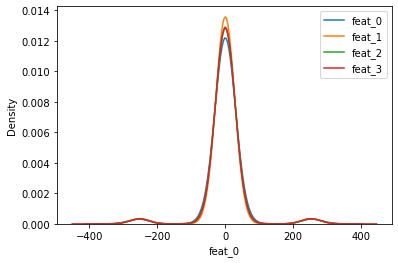

In [10]:
#Let's do density plots to confirm this; first aggregated then grouping by machine.
#Let's look at each feature individually, to confirm the distributions and hence outlier criteria are simialr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style()
features = ['feat_0', 'feat_1', 'feat_2', 'feat_3']
for feat in features:
    sns.kdeplot(df[feat], bw=0.5)
plt.legend(labels=features)


#This does seem to be the case.

In [53]:
#Let's filter out anything with abs > 200 which is clearly an outlier, then check the distributions again. Let's use a new
#dataframe for this, as we still want to keep the original intact.
df_filter = df.copy()
for feat in features:
    df_filter[feat] = df_filter[feat].apply(lambda x: np.NaN if abs(x) > 200 else x)

In [12]:
#Let's count the outliers by timestamp to see if there were certain pairs of time-features which seem to be more prone to being
#faulty. This could potentially help the client identify the cause of at least some of the problems.
group_time = df_filter.groupby('timestamp')
pd.set_option("display.max_rows", None, "display.max_columns", None)
g = group_time.apply(lambda x: x.isna().sum())

print(g.describe())

#Nothing pops out at this time, but it could be worth looking into further

#Let's run one more check, grouping by machines.

group_machine = df_filter.groupby('machine')
m = group_machine.apply(lambda x: x.isna().sum())

print(m.describe())
#It seems like measurements for all of the machines faltered at about the same rate: around 4.9% of the time.

       timestamp  machine       feat_0       feat_1       feat_2       feat_3
count     3000.0   3000.0  3000.000000  3000.000000  3000.000000  3000.000000
mean         0.0      0.0     0.975667     0.973667     0.978000     0.971667
std          0.0      0.0     0.954312     0.980796     0.972196     0.958386
min          0.0      0.0     0.000000     0.000000     0.000000     0.000000
25%          0.0      0.0     0.000000     0.000000     0.000000     0.000000
50%          0.0      0.0     1.000000     1.000000     1.000000     1.000000
75%          0.0      0.0     2.000000     2.000000     2.000000     2.000000
max          0.0      0.0     5.000000     6.000000     6.000000     5.000000
       timestamp  machine      feat_0      feat_1      feat_2      feat_3
count       20.0     20.0   20.000000   20.000000   20.000000   20.000000
mean         0.0      0.0  146.350000  146.050000  146.700000  145.750000
std          0.0      0.0    2.183069    2.163696    1.976174    1.681947
mi

             feat_0        feat_1        feat_2        feat_3
count  57073.000000  57079.000000  57066.000000  57085.000000
mean       0.033093      0.002540      0.010425     -0.027227
std       12.887757      3.409837      8.989048     10.048380
min      -78.369802    -42.185373    -54.242504   -116.809275
25%       -0.009399     -0.009514     -0.009429     -0.009463
50%        0.000068     -0.000145      0.000003     -0.000067
75%        0.009505      0.009351      0.009418      0.009442
max       80.057881     44.112802     47.545806    119.840554


C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is 

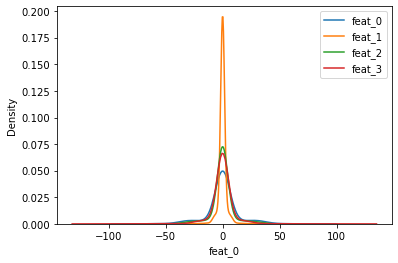

In [13]:
#Let's get back to filtering. We've removed the first "set" of outliers; now let's see if any groups of outliers appear in the
#new dataset

print(df_filter.describe())

for feat in features:
    sns.kdeplot(df_filter[feat], bw=0.5, cbar = True)
plt.legend(labels=features)

#If there are outliers due to mismeasurements, they are probably just individual points and not large groups. One thing we notice,
#though, is that the distributions of the features become markedly different when we remove the outliers. This could be due to
#different distributions in "broken" measurements, or it could be simply due to different distributions in "normal" / "faulty" measurements.
#Based on cells 14 and 17, it seems like the apparaent differences in distribution near 0 here are likely caused by the
#differences in amplitudes for "normal" behavior of the features. For instance, feature 1 has the lowest amplitude, meaning that
#normal observations are on average much closer to 0. This probably accounts for the orange spike in the density plot below.

C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\brlam\miniconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is 

,feat_0,feat_1,feat_2,feat_3
count,43826.000000,43997.000000,4.377000e+04,43878.000000
mean,-0.000005,-0.000113,-1.876509e-05,0.000011
std,0.010235,0.010883,1.016609e-02,0.010319
min,-0.091036,-0.098780,-9.772772e-02,-0.094622
25%,-0.006829,-0.006895,-6.777341e-03,-0.006746
50%,0.000035,-0.000132,-2.492895e-07,-0.000061
75%,0.006723,0.006715,6.786913e-03,0.006773
max,0.075304,0.099137,9.385396e-02,0.097432


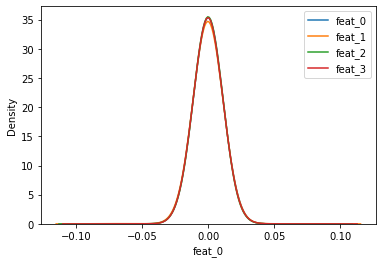

In [14]:
#It might be interesting to see what happens to the density plots if we restrict our domain to being close to 0; say (-.1, .1)
#to specifically target the "broken" state (some "normal" or "faulty" values could coincidentally be near 0, but we are looking)
#for general patterns here

df_broken = df.copy()
for feat in features:
    df_broken[feat] = df_broken[feat].apply(lambda x: np.NaN if abs(x) > 0.1 else x)
    
for feat in features:
    sns.kdeplot(df_broken[feat], bw=0.5, cbar = True)
plt.legend(labels=features)

df_broken.describe()

#They do appear to be the same (normal) distribution. It seems that (see below) the difference in amplitudes for "normal" and "faulty"
#behavior of the features are causing the apparent but deceptive difference in distributions around 0 for the features.

In [15]:
#Let's now convert to a 3 dimensional array. We want the dimensions to represent "time", "machine", and "feature". Let's
#label this as "inputs" as it will presumably be used as an input for the pipeline.

print("Shape of df_filter: " + str(df_filter.shape))

#First let's widen the data using a pivot
df_pivot = df_filter.pivot(index = 'timestamp', columns = 'machine', values = features)
#Recall that features is the list [feat_0, feat_1, feat_2, feat_3]

print("Shape of df_pivot:" + str(df_pivot.shape))

#Next, let's rearrange the columns so that we can reshape

cols_new = []
for i in range(20):
    for j in range(4):
        val = [str("feat_" + str(j)), str("machine_" + str(i))]
        cols_new.append(val)

df_pivot = df_pivot[cols_new]

#Now, let's convert to a numpy array and reshape

array_wide = df_pivot.to_numpy(copy = True)

array_3d = np.reshape(array_wide, (3000, 20, 4))
print(array_3d[0]) #This gives us the values for all machines (rows) for all features (columns) at timestamp 2019-01-01 00:00:00.000000
#We notice that all of the "normal" machines exhibit strikingly similar behavior; more on this later

Shape of df_filter: (60000, 6)
Shape of df_pivot:(3000, 80)
[[ 12.62609631   8.80311979 -11.80920018  10.08396113]
 [ 12.58824271   8.82971843 -11.80347426  10.08310697]
 [ 12.61029034   8.824032   -11.8117864   10.08418381]
 [ 12.60228229   8.83570496 -11.79057198  10.08307148]
 [-32.44552437  -2.76595389          nan          nan]
 [ 12.59777653   8.8369013  -11.79988885  10.08994771]
 [ 12.61284576   8.8248036  -11.80119068  10.08424004]
 [ 12.60144411   8.82870081 -11.77895651  10.07450134]
 [ 12.60962426   8.82508916 -11.8016882   10.08324126]
 [ 12.60966207   8.82401841 -11.77744106  10.06581853]
 [ 12.60695865   8.83367515 -11.8000371   10.07166056]
 [ 12.61919007   8.82295079 -11.78629161  10.06452814]
 [ 12.60478027   8.83998793 -11.78372067  10.06410195]
 [ 12.6299113    8.82211515 -11.78707358  10.06738196]
 [ 12.63000933          nan -11.78971714  10.06909021]
 [ 12.60658087   8.81729634 -11.78745503  10.07875513]
 [ 12.62336292   8.8200458  -11.80886999  10.073501  ]
 [ 12

In [16]:
#Create labels for xarray coordinates

#Time coordinates
time_coords = pd.date_range(start = '2019-01-01 00:00:00.000000', end = '2021-09-27 00:00:00.000000', periods = 3000)
#Machine coordinates
machine_coords = []
for i in range(20):
    machine_coords.append(str("machine_" + str(i)))
#Feature coordinates
feat_coords = []
for j in range(4):
    feat_coords.append(str("feat_" + str(j))) 


#Finally, let's convert to an xarray. Let's call this array "inputs" as it will likely serve as the input layer for the ML pipeline
inputs = xr.DataArray(data = array_3d, dims = ["timestamp", "machine", "feature"],
                     coords = [time_coords, machine_coords, feat_coords])

#Verify "inputs"
print(inputs[2,8,3])
#Labels are correct, let's make sure the value is too

df_filter[df_filter["machine"] == "machine_8"].iloc[2][5] #We filter to the matching machine (machine 8). This gives us a dataframe
#of all features for machine 8 ordered by time. We want the 3rd row and the column for feature 3, which is column 6.

#Values match

<xarray.DataArray ()>
array(-1.34576202)
Coordinates:
    timestamp  datetime64[ns] 2019-01-01T16:00:19.206402134
    machine    <U10 'machine_8'
    feature    <U6 'feat_3'


-1.3457620187096762

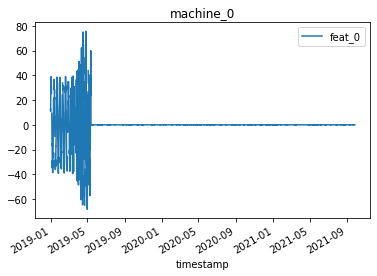

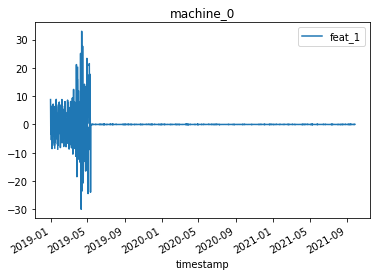

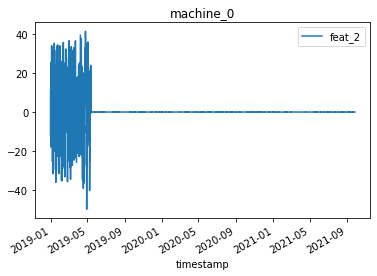

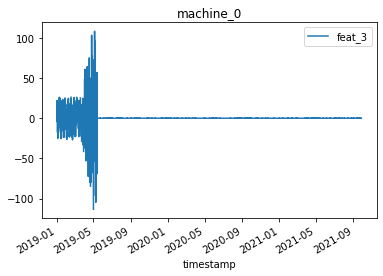

In [17]:
#Let's do some basic visualizations

#Time series graph showing all features for one of the machines.

m_0 = df_filter[df_filter['machine'] == "machine_0"]
for feat in features:
    m_0.plot('timestamp', feat, title = 'machine_0')

#"Normal" functioning seems to be quasi-sinusoidal. The amplitudes are about 40 for feats 0 & 2, 10 for feat 1, and 25 for
#feat 3. As the machine goes into "faulty" state, the behavior becomes more erratic and amplitude increases drastically for all
#features except feature 2. This behavior seems to be consistent across all machines.



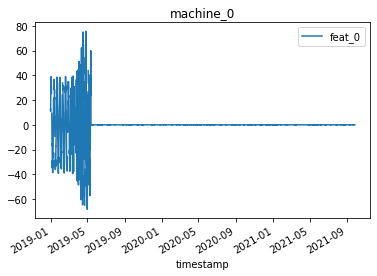

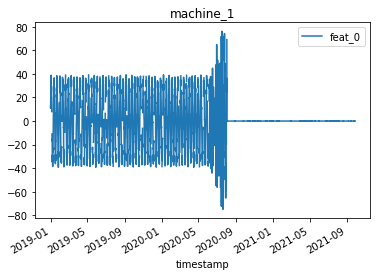

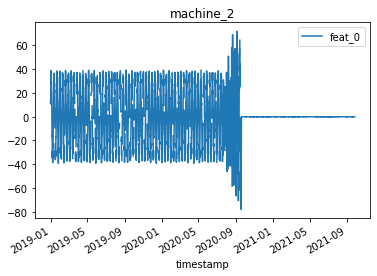

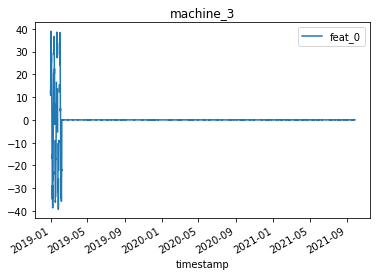

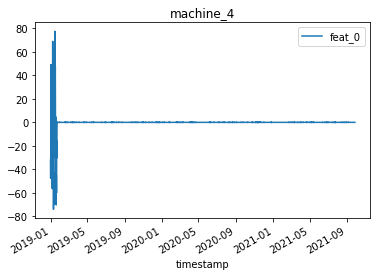

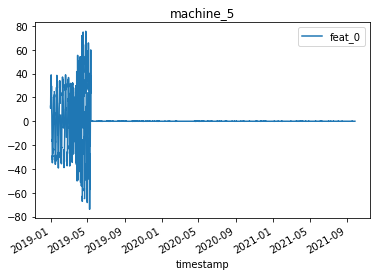

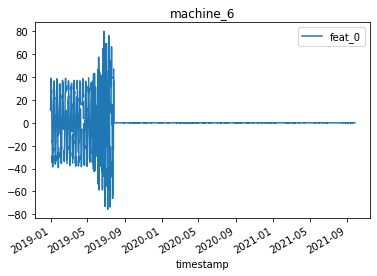

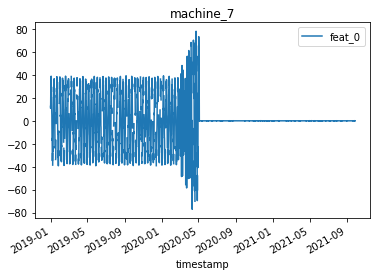

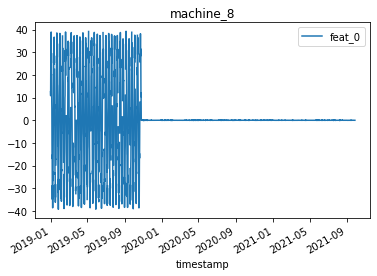

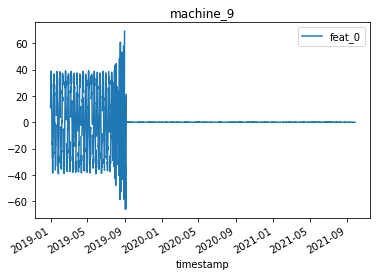

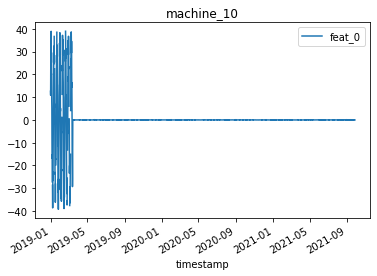

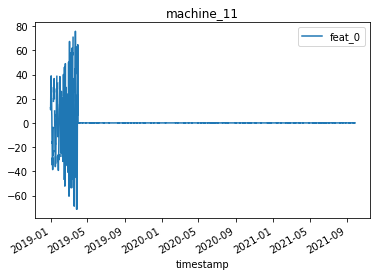

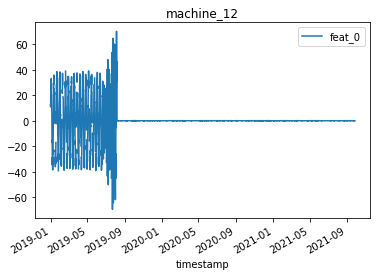

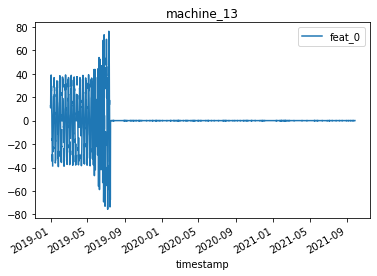

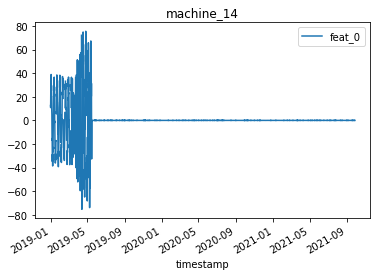

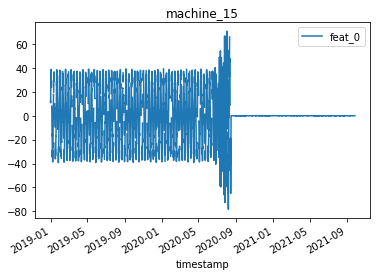

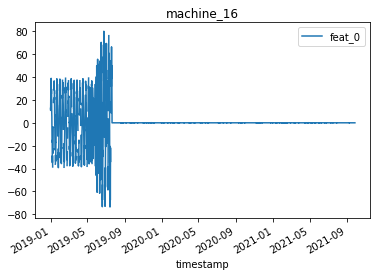

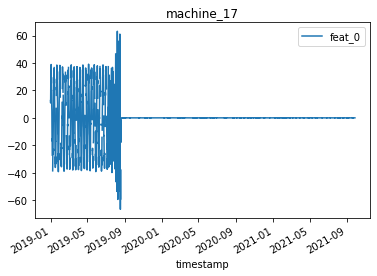

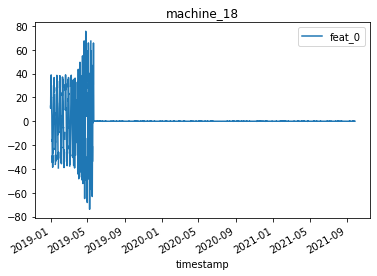

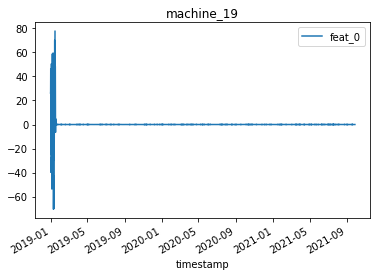

In [18]:
#Time series graph showing feat 0 for each of the machines.
for i in range(20):
    f_0 = df_filter[df_filter['machine'] == str("machine_" + str(i))]
    f_0.plot('timestamp', 'feat_0', title = str("machine_" + str(i)))
    
#As expected, the "normal" behaving machines look very similar. Some of the machines go into "faulty" mode before breaking; others
#appear to break suddenly. Similar behavior is seen for the other features.

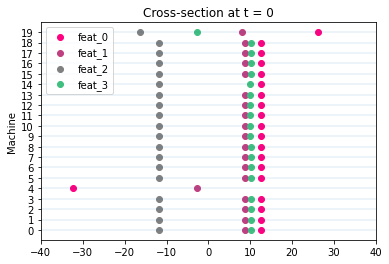

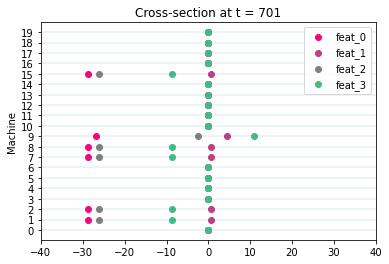

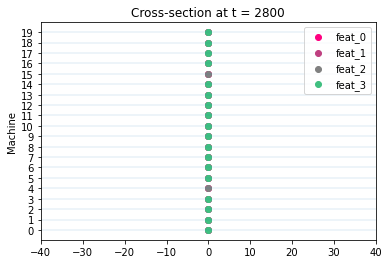

<Figure size 432x288 with 0 Axes>

In [19]:
#Cross-sectional graphs showing all of the features for all of the machines at t = 0, 701, and 2800

#t = 0
t_0 = df_filter[df_filter['timestamp'] == '2019-01-01']
y_value = 0
for i in range(20):
    color_var = 0
    for feat in features:
        x = t_0[feat][t_0['machine'] == str('machine_' + str(i))]
        y = np.zeros_like(x) + y_value
        plt.scatter(x, y, color = (1 - color_var, color_var, .5))
        color_var = color_var + .25
    y_value = y_value + 1
plt.yticks(np.arange(20))
plt.legend(labels = features)

#I needed to write a separate loop for this in order to have the legend be correct
y_value = 0
for i in range(20):
    plt.axhline(y = y_value, alpha = .1)
    y_value = y_value + 1
plt.xlim(-40, 40)
plt.ylabel("Machine")
plt.title('Cross-section at t = 0')
plt.show()
#At t = 0, machines 4 and 19 are faulty and the rest are normal
plt.clf()


#t = 701
t_701 = df_filter[df_filter['timestamp'] == '2019-08-22 17:52:11.843947'] #Timestamp for t = 701
y_value = 0
for i in range(20):
    color_var = 0
    for feat in features:
        x = t_701[feat][t_701['machine'] == str('machine_' + str(i))]
        y = np.zeros_like(x) + y_value
        plt.scatter(x, y, color = (1 - color_var, color_var, .5))
        color_var = color_var + .25
    y_value = y_value + 1
plt.yticks(np.arange(20))
plt.legend(labels = features)
y_value = 0
for i in range(20):
    plt.axhline(y = y_value, alpha = .1)
    y_value = y_value + 1
plt.xlim(-40, 40)
plt.ylabel("Machine")
plt.title('Cross-section at t = 701')
plt.show()
#At t = 700, machine 9 is faulty, machines 1, 2, 7, 8, and 15 are normal, and the rest are broken
plt.clf()


#t = 2800
t_2800 = df_filter[df_filter['timestamp'] == '2021-07-22 15:28:08.962987'] #Timestamp for t = 701
y_value = 0
for i in range(20):
    color_var = 0
    for feat in features:
        x = t_2800[feat][t_2800['machine'] == str('machine_' + str(i))]
        y = np.zeros_like(x) + y_value
        plt.scatter(x, y, color = (1 - color_var, color_var, .5))
        color_var = color_var + .25
    y_value = y_value + 1
plt.yticks(np.arange(20))
plt.legend(labels = features)
y_value = 0
for i in range(20):
    plt.axhline(y = y_value, alpha = .1)
    y_value = y_value + 1
plt.xlim(-40, 40)
plt.ylabel("Machine")
plt.title('Cross-section at t = 2800')
plt.show()
#At t = 2800, all machines are broken
plt.clf()

In [54]:
#Finally, let's (conservatively) determine the "normal" feature-time pairs if all the machines were working.
#We will round the values to nearest 10th, drop values close to 0, and take the mode across the rest (min 2 values). This method is
#definitely flawed, and given more time I would implement a better one. However, I think it's a good starting place.

import statistics as stats

df_nonzero = df_filter.copy()
for feat in features:
    df_nonzero[feat] = df_nonzero[feat].apply(lambda x: np.NaN if abs(x) < 0.1 else x)
df_nonzero = df_nonzero.round(1)

#Define function for retrieving normal value
def normal_value(x):
    if len(x.dropna().value_counts()) > 0:
        if max(x.dropna().value_counts()) > 1:
            return x.dropna().value_counts().index[0]
    return np.nan

df_nonzero.drop(columns = 'machine')
normal_behavior = df_nonzero.groupby(['timestamp']).agg(normal_value)

normal_behavior.head()


,machine,feat_0,feat_1,feat_2,feat_3
timestamp,,,,,
2019-01-01 00:00:00.000000,NaN,12.6,8.8,-11.8,10.1
2019-01-01 08:00:09.603201,NaN,10.8,2.8,11.6,21.9
2019-01-01 16:00:19.206402,NaN,21.1,-0.7,-17.8,-1.4
2019-01-02 00:00:28.809603,NaN,32.3,6.5,-13.5,-4.3
2019-01-02 08:00:38.412804,NaN,28.1,3.7,22.0,13.6
